In [1]:
import pandas as pd
import numpy as np
from pandas_visual_analysis import VisualAnalysis
import matplotlib.pyplot as plt
import json
from collections import OrderedDict
import collections
from datetime import date
import time
import csv
from pandas import Series

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb

In [2]:
df_train = pd.read_csv('./csv/abusingDetectionTrainDataset.csv')
df_test = pd.read_csv('./csv/abusingDetectionTestDataset.csv')
print(df_train.shape)
print(df_test.shape)


(104399, 44)
(44736, 43)


# Feature

In [3]:
# -- 삭제 -- 
# socialBooleanB, accountMetaAmountA, charSessionAmountB, tradeSessionAmountC, tradeSessionAmountE
df_train = df_train.drop(['socialBooleanB', 'accountMetaAmountA', 'charSessionAmountB', 'tradeSessionAmountC', 'tradeSessionAmountE'], axis=1)
df_test = df_test.drop(['socialBooleanB', 'accountMetaAmountA', 'charSessionAmountB', 'tradeSessionAmountC', 'tradeSessionAmountE'], axis=1)

# logging_timestamp에서 시간단위로 새로운 컬럼 추가
data_hour_train = pd.to_datetime(df_train['logging_timestamp']).dt.strftime('%H').astype(int)
data_hour_train = data_hour_train.replace(0, 24)
df_train['date_hour'] = data_hour_train

data_hour_test = pd.to_datetime(df_test['logging_timestamp']).dt.strftime('%H').astype(int)
data_hour_test = data_hour_test.replace(0, 24)
df_test['date_hour'] = data_hour_test


# tradeSessionAmount A, B, D  ==> tradeSessionAmount 
tradeSessionAmount_train = df_train['tradeSessionAmountA'] + df_train['tradeSessionAmountB'] + df_train['tradeSessionAmountD']
df_train = df_train.drop(['tradeSessionAmountA', 'tradeSessionAmountB', 'tradeSessionAmountD'], axis=1)
df_train['tradeSessionAmount'] = tradeSessionAmount_train

tradeSessionAmount_test = df_test['tradeSessionAmountA'] + df_test['tradeSessionAmountB'] + df_test['tradeSessionAmountD']
df_test = df_test.drop(['tradeSessionAmountA', 'tradeSessionAmountB', 'tradeSessionAmountD'], axis=1)
df_test['tradeSessionAmount'] = tradeSessionAmount_test


# charSessionAmountC, actionSessionAmountM 제거
df_train = df_train.drop(['charSessionAmountC', 'actionSessionAmountM'], axis=1)
df_test = df_test.drop(['charSessionAmountC', 'actionSessionAmountM'], axis=1)

# socialSessionAmountB
socialSessionAmountB_train = df_train['socialSessionAmountB']
socialSessionAmountB_train = [i*10 if i == 0 else 0 for i in socialSessionAmountB_train]
df_train = df_train.drop(['socialSessionAmountB'], axis=1)
df_train['socialSessionAmountB'] = socialSessionAmountB_train

socialSessionAmountB_test = df_test['socialSessionAmountB']
socialSessionAmountB_test = [i*10 if i == 0 else 0 for i in socialSessionAmountB_test]
df_test = df_test.drop(['socialSessionAmountB'], axis=1)
df_test['socialSessionAmountB'] = socialSessionAmountB_test

# logging_timestamp
df_train = df_train.drop(['logging_timestamp'], axis=1)
df_test = df_test.drop(['logging_timestamp'], axis=1)

print(df_train.shape)
print(df_test.shape)

(104399, 35)
(44736, 34)


In [4]:
# Data separation
target_label = df_train['blocked'].values

df_x_train, df_x_valid, y_train, y_valid = train_test_split(df_train, target_label, test_size=0.2, random_state=None)

In [5]:
data_result_10 = pd.DataFrame(df_x_valid['newID'])
data_result_10['res'] = 0

data_result = pd.DataFrame(df_x_valid['newID'])
data_result = data_result.drop_duplicates()
data_result['res'] = 0

df_x_train = df_x_train.drop(['blocked'], axis=1)
df_x_valid = df_x_valid.drop(['blocked'], axis=1)
df_x_train = df_x_train.drop(['newID'], axis=1)
df_x_valid = df_x_valid.drop('newID', axis=1)

df_x_train.shape, df_x_valid.shape, y_train.shape, y_valid.shape

((83519, 33), (20880, 33), (83519,), (20880,))

In [6]:
x_train = df_x_train.values
x_valid = df_x_valid.values

In [7]:
# n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf
#model = RandomForestClassifier(random_state=42)
#model = RandomForestClassifier(criterion='entropy', n_estimators=10, n_jobs=10, random_state=1)
model = RandomForestClassifier(n_estimators=130, n_jobs=10, random_state=123456)

model.fit(x_train, y_train)
prediction = model.predict(x_valid)

# 결과

In [8]:
print("Test results:\n")
print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_valid, model.predict(x_valid))))
print('Classification Report:\n{}\n'.format(classification_report(y_valid, model.predict(x_valid))))
print('Confusion Matrix:\n{}\n'.format(confusion_matrix(y_valid, model.predict(x_valid))))

Test results:

Accuracy Score: 0.8456

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.65      0.77      8378
           1       0.81      0.98      0.88     12502

    accuracy                           0.85     20880
   macro avg       0.88      0.81      0.83     20880
weighted avg       0.86      0.85      0.84     20880


Confusion Matrix:
[[ 5455  2923]
 [  301 12201]]



# lightGBM

In [9]:
train_ds = lgb.Dataset(x_train, label = y_train)
test_ds = lgb.Dataset(x_valid, label = y_valid)
params = {'learning_rate': 0.01,
          'max_depth': 16,
          'boosting': 'gbdt',
          'objective': 'binary',
          'metric': 'binary_logloss',
          'is_training_metric': True,
          'num_leaves': 144,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.7,
          'bagging_freq': 5,
          'seed':2020}

In [10]:
model2 = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)
y_pred=model2.predict(x_valid)

[LightGBM] [Info] Number of positive: 49958, number of negative: 33561
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2662
[LightGBM] [Info] Number of data points in the train set: 83519, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598163 -> initscore=0.397818
[LightGBM] [Info] Start training from score 0.397818
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.445719
[200]	valid_0's binary_logloss: 0.390722
[300]	valid_0's binary_logloss: 0.372799
[400]	valid_0's binary_logloss: 0.365362
[500]	valid_0's binary_logloss: 0.362302
[600]	valid_0's binary_logloss: 0.360564
[700]	valid_0's binary_logloss: 0.359625
[800]	valid_0's binary_logloss: 0.358915
[900]	valid_0's binary_logloss: 0.358289
[1000]	val

In [11]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_x_valid.columns)

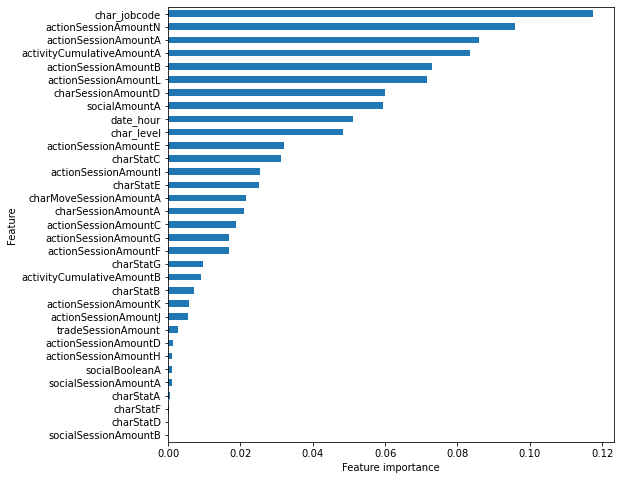

In [12]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

# 결과 반영

### 테스트 데이터셋 - abusingDetectionTestDataset.csv

In [13]:
data_result_10['res'] = prediction
list_result = np.array(data_result_10)

set_result = []
for itm in list_result:
    if itm[1] == 1:
        set_result.append(itm[0])

set_result = list(set(set_result))

for itm in list_result:
    if itm[0] in set_result:
        list_result[1] = 1
        
chk_result = []
for itm in list_result:
    chk_result.append(itm[1])

In [14]:
test_result = pd.DataFrame(df_test['newID'])
test_result['res'] = 0

df_test = df_test.drop(['newID'], axis=1)

X_test = df_test.values
prediction = model.predict(X_test)

test_result['res'] = prediction
list_test_result = np.array(test_result)

In [15]:
set_final_result = []
for itm in list_test_result:
    set_final_result.append(itm[0])
set_final_result = list(set(set_final_result))

final_result_blocked = np.array([0 for i in range(len(set_final_result))])

In [16]:
for itm in list_test_result:
    if itm[1] == 1:
        final_result_blocked[np.where(set_final_result == itm[0])] = 1

final_result = []

for _a, _b in zip(set_final_result, final_result_blocked):
    final_result.append([_a, _b])

In [17]:
with open('./csv/result.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['newID', 'res'])
    for i in final_result:
        writer.writerow([i[0], i[1]])